## Creating PRS sequences
**WHAT IS SYSTEM GENERAL PARAMETERS????**

## signal design for NR PRS


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def PNSequence_5g(n_s_f, l,  Mpn, n_PRS_ID, N_slot_symb ):

    """
    input Parameter Description:
        ns: time slot number
        n:_PRS_ID: slot_symb --- PRS sequence ID {0, 1,...,4095}, N_slot_symb
        l: OFDM symbol in time slot ns
        Mpn: pseudo-random sequence length
        BSID: base station number in the cellular network
        Ncp: cyclic prefix length
    output: Parameter detection:
        C: ???????????? 
    """
   

    #Initial conditions
    Nc = 1600
    sequence = np.empty((len(l), Mpn, len(n_s_f)), dtype = int)
    for n_s in n_s_f:
        S = np.empty((len(l), Mpn))
        for i in range(len(l)):
            C = np.zeros((Mpn), dtype = int)#.tolist()
            Cinit = np.mod(((2**22)*np.floor(n_PRS_ID[n_s]/1024) + (2**10)*(N_slot_symb*n_s+l[i]+1)\
                            *(2*np.mod(n_PRS_ID[n_s],1024)+1) + np.mod(n_PRS_ID[n_s],1024)), 2**31)
            #Cinit=(2^10)*(7*(ns+1)+l+1)*(2*BSID+1)+2*BSID+Ncp
            #  31 Gold 
        
            X1 = np.zeros((31), dtype = int)#.tolist()
            X1[0] = 1
            X2 = np.array([int(i) for i in np.binary_repr(int(Cinit), 31)[::-1]]) #.tolist()
        
            for n in np.arange(0, Mpn+Nc-31, 1):
            #X1[n+30 +1] = 11 #np.mod(X1[n+3+1] + X1[n+1], 2)
            #X2[n+30 +1] = 12 #np.mod(X2[n+3+1]+X2[n+2+1]+X2[n+1+1]+X2[n+1],2)
                X1 = np.append(X1, [np.mod((X1[n+3] + X1[n]), 2)])
                X2 = np.append(X2, [np.mod(X2[n+3] + X2[n+2] + X2[n+1] + X2[n], 2)])

            
        # alpha
            for n in np.arange(0, Mpn, 1):
                C[n] = np.mod(X1[n+Nc] + X2[n+Nc],2)
                
            S[i,:] = C
        
        sequence[:,:,n_s] = S
    
    return sequence

## MAPPING PNS to PRS 

In [3]:
def PRSSequence_5g(NPRB, MaxNDRB, lstart, l, N, n_s_f, n_PRS_ID, K_PRS_comb, beta_PRS, PNS): 


#  PRSSequence  This program generates positioning reference signal sequence
#  Parameter Description:
#  NDRB：number of downlink resource blocks
#  NPRB：  number of positioning reference signal resource blocks
#  l：     OFDM symbol number in time slot ns
#  BSID：  base station number
#  ns：    time slot number
#  Ncp：   cyclic prefix length
#  Parameter detection
#l=l_PRS_start,l_PRS_start+1,...,l_PRS_start+L_PRS-1
#L_PRS=2，4，6，12L_PRS=2,4,6,12 ---- PRS resource size in the time slot L_PRS=2, 4, 6, 1
#k_PRS_offsetRE：={0，1，。。，K_PRS_comb-1} ---- k_PRS_offsetRE: offset={0,1,. . , K_PRS_comb-1

    
    

    

    #k_PRS_offset = 0

    #l = np.arange(lstart,lstart+L_PRS-1,1)
    k_prime_comb6 = [0,3,1,4,2,5,0,3,1,4,2,5]
    #k_prime_comb4 = [0,2,1,3,0,2,1,3,0,2,1,3]    
    
    
    PRS = np.empty((N,14,len(n_s_f)), dtype=complex)
    for n_s in range(len(n_s_f)):
        PRS_temp = np.zeros((N,14), dtype=complex)
        k_PRS_offset = np.mod(n_s_f[n_s], 6) #Frequency shift --> occupied 2 unique PRS in one slot
        """if  k_PRS_offset == 0:
            k_PRS_offset += 1 #for frequency offset in the first PRS OFDM symbol --> +2 for first PRS ID and +4 for the second one
        if  k_PRS_offset == 1:
            k_PRS_offset += 2 
        if  k_PRS_offset == 2:
            k_PRS_offset += 3"""

        for ll in range(len(l)):
            k1 = k_prime_comb6[l[ll]-lstart]
            c = PNS[ll,:,n_s]
            
            r  = np.zeros((NPRB + MaxNDRB), dtype = complex)#.tolist()
            X = np.zeros((N), dtype = complex)
            
            for m in np.arange(0, 2*NPRB, 1):
                k  = m * K_PRS_comb + np.mod((k_PRS_offset + k1), K_PRS_comb)
                    # K_PRS_comb=2,4,6,12;   k_PRS_offset={0,1,...,K_PRS_comb-1}
                r[m] = (1/(np.sqrt(2)))*(1-2*c[2*m]) + 1j*(1/np.sqrt(2))*(1-2*c[2*m+1])
                X[k] = beta_PRS*r[m]
                
                PRS_temp[:,l[ll]] = X
        
        PRS[:,:, n_s] = PRS_temp

    return PRS

## making Positioning number sequences 

In [4]:
#Sequence generation 
#ns = 1
lstart = 2
L_PRS = 6
K_PRS_comb = 6 #comb6 means {L_PRS = 6 --> number of filled symbols in time domain -1, K_PRS_comb = 6 --> factor of PRS repetition within one symbol}

l = [i for i in range(lstart, lstart+L_PRS-1, 1)] #symbol indices from the first filled symbol, i.e., lstart = 2 to the L_PRS - 1
print(f'symbol indices for PRS blocks are {l}')
MaxNDRB = 273 #Maximum number of downlink resource blocks
NPRB = 139 #number of positioning resource block --> 100*12*60 = 72 MHz BW
Mpn = (MaxNDRB + NPRB)*2 #Pseudo-random sequence length


N_slot_symb = 14 #number of slots per symbol --> used of making GOld sequence 14 for normal CP and 12 for extended CP
num_BS = 18
n_s_f = [i for i in np.arange(0, num_BS, 1)] #slot number --> different slot index for differne BSs
#n_PRS_ID = [i for i in range(0, num_BS, 1)] #downlink PRS sequence ID {0,1,...4095}
np.random.seed(873)
n_PRS_ID = np.random.randint(0, 4095,len(n_s_f), dtype = int).tolist()

PNS = PNSequence_5g(n_s_f, l,  Mpn, n_PRS_ID, N_slot_symb) #making Positioning NUmber sequences
print(f'the shape of PNS is {PNS.shape}')


symbol indices for PRS blocks are [2, 3, 4, 5, 6]
the shape of PNS is (5, 824, 18)


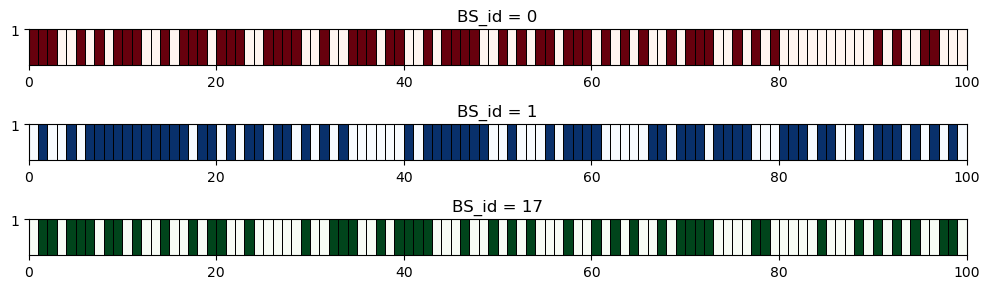

In [5]:
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize = (10,3))


#c = ax.pcolor(a, edgecolors='k', linewidths=2, cmap='red')
ax1.pcolormesh(PNS[np.newaxis, 0,0:100,0], edgecolors='black', cmap="Reds", linewidths=0.5)
#plt.pcolor(a, edgecolors='k', linewidths=2, cmap="Spectral",  )
ax1.set_title('BS_id = 0')
ax1.set_yticks((0,1))
ax1.set_ylim(0.5)

ax2.pcolormesh(PNS[np.newaxis, 0,0:100,1], edgecolors='black', cmap="Blues", linewidths=0.5)
ax2.set_title('BS_id = 1')
ax2.set_yticks((0,1))
ax2.set_ylim(0.5)

ax3.pcolormesh(PNS[np.newaxis, 0,0:100,17], edgecolors='black', cmap="Greens", linewidths=0.5)
ax3.set_title('BS_id = 17')
ax3.set_yticks((0,1))
ax3.set_ylim(0.5)

fig.tight_layout()

plt.show()

In [6]:
 #k_PRS_offset = mod(n_PRS_ID, K_PRS_comb) --- Frequency shift
N = 2048
beta_PRS = 1


#PRS should be a single-column vector of frequency coefficients for 3276 subcarriers. 100MHz -> 273 RB x 12 = 3276 SC;
PRS_sequence_mapped = PRSSequence_5g(NPRB, MaxNDRB, lstart, l, N, n_s_f, n_PRS_ID, K_PRS_comb, beta_PRS, PNS)
print(f'the shape of PRS is {PRS_sequence_mapped.shape}')
#%store PRS_sequence_mapped

the shape of PRS is (2048, 14, 18)


In [7]:
np.unique(abs(PRS_sequence_mapped[:,2,0]), return_counts = True)

(array([0., 1.]), array([1770,  278]))

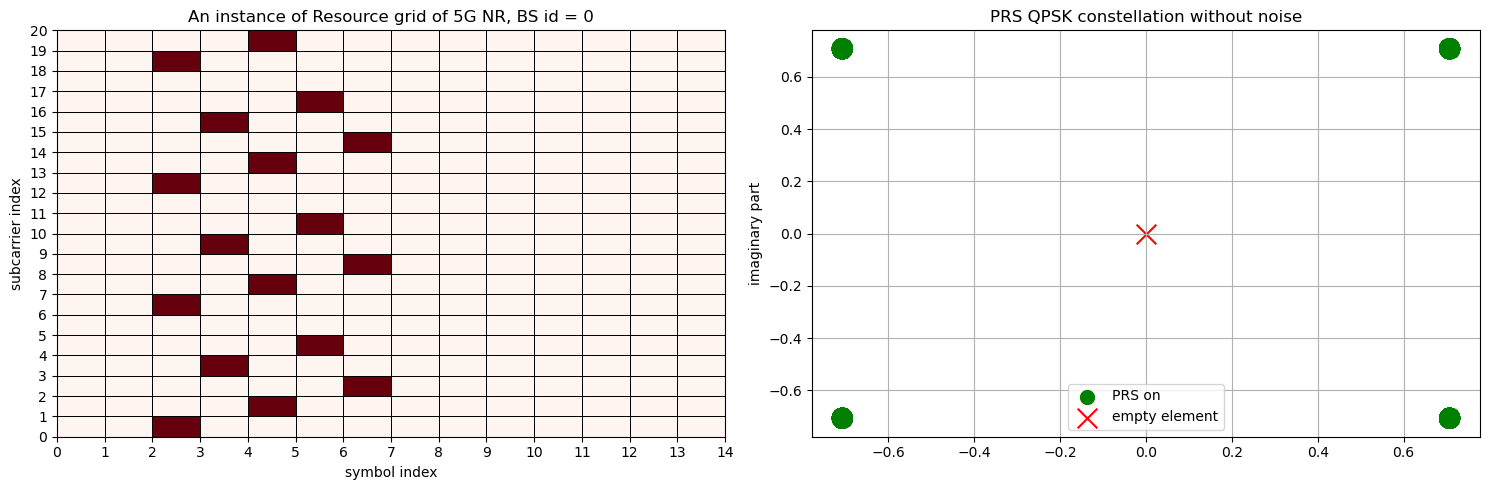

In [8]:
#a = np.linspace(start = 0, stop = 14, num = 1)
#b = np.linspace(start = 0, stop = 20, num = 1)
#c = PRS_sequence_mapped[0:20]
#fig, ax = plt.subplots(figsize = (10,5.5))

#m = ax.pcolor(c)
#ax.set_title('default: no edges')

#c = ax.pcolor(a, edgecolors='k', linewidths=2, cmap='red')
fig , (ax1,ax2) = plt.subplots(1,2, figsize = (15,5))
ax1.pcolormesh(abs(PRS_sequence_mapped[0:20,:,0]), edgecolor = 'k', linewidth = 0.5, cmap="Reds")
ax1.set_title('An instance of Resource grid of 5G NR, BS id = 0')
ax1.set_yticks(np.arange(0,21,1))
ax1.set_xticks(np.arange(0,15,1))
ax1.set_xlabel('symbol index')
ax1.set_ylabel('subcarrier index')

x,y = PRS_sequence_mapped[:,3,0].real, PRS_sequence_mapped[:,3,0].imag
r = 200*(abs(PRS_sequence_mapped[:,3,0]))**2
area1 = np.ma.masked_where(r == 200, r)
ax2.scatter(x, y, s = area1, marker = 'o', c = 'green')
ax2.scatter(x[1], y[1], s = 200, marker = 'x', c = 'red')
ax2.legend(['PRS on', 'empty element'], loc = 'lower center')
ax2.set_title('PRS QPSK constellation without noise')
ax2.set_xlabel('real part')
ax2.set_ylabel('imaginary part')
ax2.grid(True)
ax2.set_xlabel('')
fig.tight_layout()
plt.show()

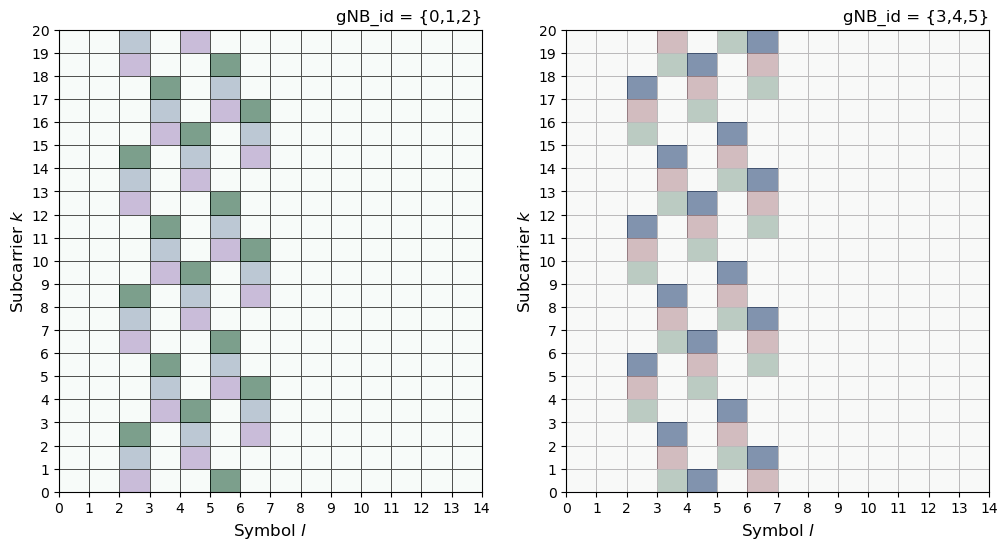

In [9]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax1.pcolormesh(abs(PRS_sequence_mapped[0:20,:,0]), cmap='Purples', alpha = 1) #cmap=plt.cm.Blues
ax1.pcolormesh(abs(PRS_sequence_mapped[0:20,:,1]), cmap='Blues', alpha = 0.5, edgecolor = 'k', linewidth = 0.5)
ax1.pcolormesh(abs(PRS_sequence_mapped[0:20,:,2]), cmap='Greens', alpha = 0.5, edgecolor = 'k', linewidth = 0.5)
ax1.set_xlabel(r'Symbol $l$', fontsize=12)
ax1.set_ylabel(r'Subcarrier $k$', fontsize=12)
ax1.set_yticks(np.arange(0,21,1))
ax1.set_xticks(np.arange(0,15,1))
ax1.set_title('gNB_id = {0,1,2}', loc = 'right')
ax2.pcolormesh(abs(PRS_sequence_mapped[0:20,:,3]), cmap='Greens', alpha = 1, edgecolor = 'k', linewidth = 0.5)
ax2.pcolormesh(abs(PRS_sequence_mapped[0:20,:,4]), cmap='Reds', alpha = 0.5, linewidth = 0.5)
ax2.pcolormesh(abs(PRS_sequence_mapped[0:20,:,5]), cmap='Blues', alpha = 0.5, linewidth = 0.5)
ax2.set_xlabel(r'Symbol $l$', fontsize=12)
ax2.set_ylabel(r'Subcarrier $k$', fontsize=12)
ax2.set_yticks(np.arange(0,21,1))
ax2.set_xticks(np.arange(0,15,1))
ax2.set_title('gNB_id = {3,4,5}', loc = 'right')
plt.show()

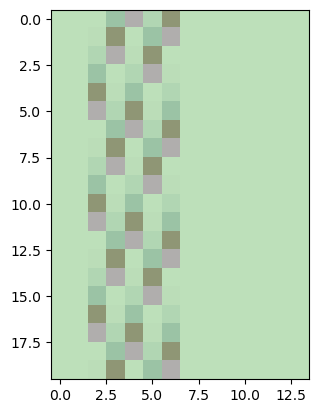

In [10]:
plt.imshow(abs(PRS_sequence_mapped[0:20,:,0]), cmap='Spectral', alpha = 0.2)
plt.imshow(abs(PRS_sequence_mapped[0:20,:,1]), cmap='Purples', alpha = 0.9)
plt.imshow(abs(PRS_sequence_mapped[0:20,:,2]), cmap='Blues', alpha = 0.8)
plt.imshow(abs(PRS_sequence_mapped[0:20,:,3]), cmap='Blues', alpha = 0.7)
plt.imshow(abs(PRS_sequence_mapped[0:20,:,4]), cmap='Reds', alpha = 0.6)
plt.imshow(abs(PRS_sequence_mapped[0:20,:,5]), cmap='Accent', alpha = 0.5) #cmap=plt.cm.Blues

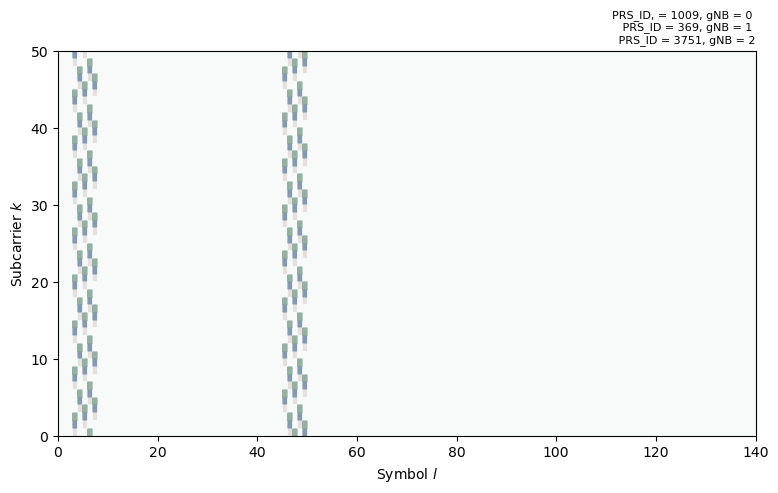

In [174]:
#d = np.random.uniform(0,1,50)
#d = np.ones((50))
import matplotlib.pyplot as plt
i = 0
a = np.zeros((50,140))
b = np.zeros((50,140))
c = np.zeros((50,140))
N_slots = 4
counter = 0
for j in np.arange(0,N_slots,1):
    if j % 3 == 0 and j != 9:
        a[:,j*N_slot_symb+1:j*N_slot_symb+N_slot_symb+1] = abs(PRS_sequence_mapped[0:50,:,counter])
        b[:,j*N_slot_symb+1:j*N_slot_symb+N_slot_symb+1] = abs(PRS_sequence_mapped[0:50,:,counter+1])
        c[:,j*N_slot_symb+1:j*N_slot_symb+N_slot_symb+1] = abs(PRS_sequence_mapped[0:50,:, counter+2])
        counter += 3
    
fig, ax = plt.subplots(1,1, figsize = (9,5))
ax.pcolor(a, cmap='Reds', alpha = 0.9)
ax.pcolor(b, cmap='Blues', alpha = 0.8)
ax.pcolor(c, cmap='Greens', alpha = 0.4)
ax.set_xlabel(r'Symbol $l$', fontsize=10)
ax.set_ylabel(r'Subcarrier $k$', fontsize=10)
ax.set_title(f'PRS_ID, = {n_PRS_ID[0]}, gNB = 0 \n PRS_ID = {n_PRS_ID[1]}, gNB = 1 \n PRS_ID = {n_PRS_ID[2]}, gNB = 2', 
             loc = 'right', fontsize = 8)
plt.show()

Text(0, 0.5, 'Subcarrier $k$')

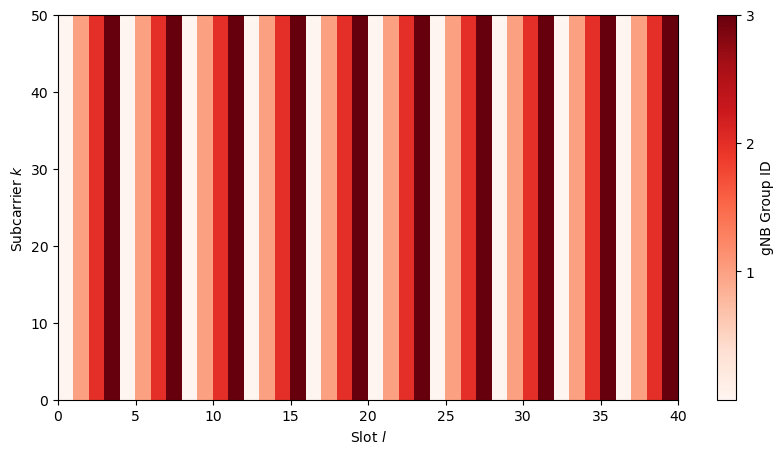

In [11]:
mu = 2
n_slot_frame = 10*2**mu
N_slot_subframe = 4
radio_frame = np.zeros((50,n_slot_frame))
counter = 0
for i in np.arange(0,n_slot_frame,4):
    for j in np.arange(0,N_slot_subframe-1,1):
        #if j % 3 == 0 and j != 9: #and j != 2*8 and j != 3*8 and j != 4*8:
            radio_frame[:,i+(j+1)] = counter +1
            counter += 1
    counter = 0



fig, ax = plt.subplots(1, 1, figsize = (10,5))
cb = ax.pcolor(radio_frame, cmap='Reds')
fig.colorbar(cb, label ='gNB Group ID', ticks = np.arange(1,4,1))
ax.set_xlabel(r'Slot $l$', fontsize=10)
ax.set_ylabel(r'Subcarrier $k$', fontsize=10)

In [12]:
# ADD cyclic prefix at the begining of PRS signal
def addCP(OFDM, CP, nFFT):
    CP = int(CP/2)
    cp = OFDM[-CP]               # take the last CP samples ...
    temp_ofdm_cp = np.hstack([cp, OFDM])
    return temp_ofdm_cp[:nFFT]  # ... and add them to the beginning

In [13]:
nFFT = 2048
CP = 208
OFDM_withCP = np.empty((nFFT,PRS_sequence_mapped.shape[1],PRS_sequence_mapped.shape[2]), dtype=complex)
for i in np.arange(PRS_sequence_mapped.shape[1]):
    for j in np.arange(PRS_sequence_mapped.shape[2]):
        OFDM_withCP[:,i,j] = addCP(PRS_sequence_mapped[:,2,1], CP, nFFT)

print ("OFDM with CP shape is: ", OFDM_withCP.shape)

OFDM with CP shape is:  (2048, 14, 18)


In [ ]:
np.save('PRS.npy', OFDM_withCP)

the shape of PRS is (2048, 14, 18)


Text(1.0, 1.0, 'BS id = 0 \n PRS ID = 1009')

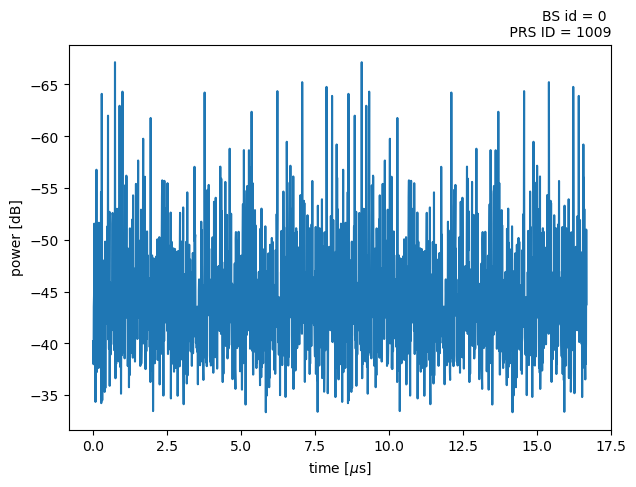

In [14]:
nFFT = 2048
Tc = 1/(480e3*4096) #0.5086 ns --> OFDM symbol duration
t_per_slot = 250 #micro second
Tc = t_per_slot/N_slot_symb #symbol duration

t = np.linspace(0, 1e3/60, nFFT)
PRS_time = np.fft.ifft(PRS_sequence_mapped,nFFT, axis = 0)
print(f'the shape of PRS is {PRS_time.shape}')
fig, ax = plt.subplots(1, 1, figsize = (7,5))
ax.plot(t,20*np.log10(abs(PRS_time[:,2,17])))
fig.gca().invert_yaxis()
ax.set_xlabel(r'time [$\mu$s]', fontsize=10)
ax.set_ylabel(r'power [dB]', fontsize=10)
ax.set_title(f'BS id = 0 \n PRS ID = {n_PRS_ID[0]}', loc = 'right', fontsize=10)

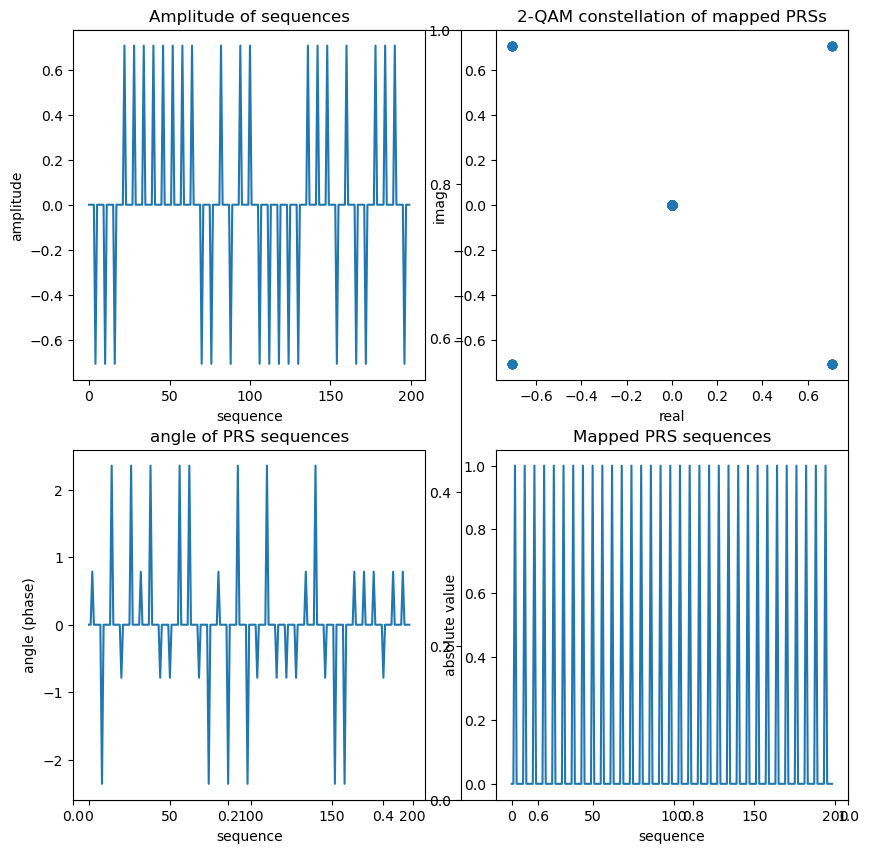

In [111]:
#plt.plot(f,abs(h),'--b')
fig, ax = plt.subplots(figsize=(10,10))
fig.add_subplot(2,2,1)  
plt.plot(PRS_sequence_mapped[200:400,2,0].real)
plt.xlabel('sequence')
plt.ylabel('amplitude')
plt.title(f'Amplitude of sequences')
fig.add_subplot(2,2,2) 
plt.plot(PRS_sequence_mapped[200:400,3,0].real, PRS_sequence_mapped[200:400,3,0].imag, 'o')
plt.xlabel('real')
plt.ylabel('imag')
plt.title(f'2-QAM constellation of mapped PRSs')
ax.spines['left'].set_position('center')
fig.add_subplot(2,2,3)  
plt.plot(np.angle(PRS_sequence_mapped[1:200,3,0]))
plt.xlabel('sequence')
plt.ylabel('angle (phase)')
plt.title(f'angle of PRS sequences')
fig.add_subplot(2,2,4)  
plt.plot(abs(PRS_sequence_mapped[1:200,3,0]))
plt.xlabel('sequence')
plt.ylabel('absolute value')
plt.title(f'Mapped PRS sequences')
plt.show()

#fig.add_subplot(2,2,1)  
#sp_los = np.fft.fft(y_LOS, nFFT)
#plt.plot(f1/1e6, 20 * np.log10(np.abs(h1)), 'b')
#plt.plot(abs(PRS_sequence_mapped))